In [1]:
# https://vanderbilt365-my.sharepoint.com/:u:/g/personal/abhishek_dubey_vanderbilt_edu/EcagKoRLKNBIjsHpkdO41J4BETM5sdDoXqbblCeRBtLPYw?e=5WSUE6

In [2]:
PROJECT_PATH = '.'

In [3]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

from shapely.geometry import *

tqdm.pandas(desc='Progress: ')

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
etrims_unit_segments_v3 = json.load(open('./resources/Etrims_Unit_Segments_v3.json'))

In [5]:
shp_list = [{'seg_id': x['properties']['seg_id'], 'line': LineString(x['geometry']['coordinates'])} for x in etrims_unit_segments_v3['features']]

len(shp_list)

2960

In [6]:
df = pd.read_csv(f'{PROJECT_PATH}/output/waze_12_raw.csv', index_col=0)

In [7]:
df.head()

,country,nThumbsUp,city,reportRating,confidence,reliability,type,uuid,roadType,magvar,subtype,street,pubMillis,lng,lat,reportDescription
0,US,0,"Nashville, TN",3,1,7,ACCIDENT,5a9e667f-3bda-3224-9662-e5a7e455f94f,3.0,233,NaN,I-40 W,1575340901000,-86.636268,36.151548,NaN
1,US,0,"Goodlettsville, TN",1,0,5,ACCIDENT,03913aca-5045-3a89-94c7-378159603e8b,3.0,56,ACCIDENT_MINOR,Vietnam Veterans Blvd,1575337336000,-86.706220,36.304490,NaN
2,US,0,"Nashville, TN",1,0,5,ACCIDENT,94be551e-412f-3961-b1ef-490cf22fee40,4.0,153,NaN,to I-24 E / Chattanooga,1575384564000,-86.698586,36.083495,NaN
3,US,0,"Nashville, TN",2,1,7,ACCIDENT,4707613e-1798-3052-bb7b-74a6647311e4,6.0,151,ACCIDENT_MAJOR,Old Hickory Blvd,1575383199000,-86.603257,36.175815,NaN
4,US,0,"Nashville, TN",2,5,10,ACCIDENT,daf0a810-a07a-34d2-bc41-1a18168ee48f,3.0,333,NaN,I-65 N,1575384364000,-86.771595,36.111977,NaN


In [8]:
points = df.progress_apply(lambda pt: Point(pt.lng, pt.lat), axis=1)

points.head()

Progress: 100%|██████████| 9897/9897 [00:00<00:00, 22661.39it/s]


0            POINT (-86.636268 36.151548)
1              POINT (-86.70622 36.30449)
2    POINT (-86.69858599999999 36.083495)
3            POINT (-86.603257 36.175815)
4    POINT (-86.77159499999999 36.111977)
dtype: object

In [9]:
def calc_dist(pt):
    return [x['line'].distance(pt) for x in shp_list]

In [10]:
# Yasas has generated this file, pls ask if required.
try:
    dist_matrix = np.load(f'{PROJECT_PATH}/output/waze_12_etrims_dist_matrix.npy')
except:
    dist_ = points.progress_apply(calc_dist)
    dist_matrix = np.array(dist_.values.tolist())
    np.save(f'{PROJECT_PATH}/output/waze_12_etrims_dist_matrix.npy', dist_matrix)

In [13]:
df['seg_id'] = [shp_list[i]['seg_id'] for i in np.argmin(dist_matrix, axis=1)]

df['seg_id_dist'] = np.min(dist_matrix, axis=1)

print('Unique Road Segments: %d' % len(set(df['seg_id'])))

df.head()

Unique Road Segments: 399


,country,nThumbsUp,city,reportRating,confidence,reliability,type,uuid,roadType,magvar,subtype,street,pubMillis,lng,lat,reportDescription,seg_id,seg_id_dist
0,US,0,"Nashville, TN",3,1,7,ACCIDENT,5a9e667f-3bda-3224-9662-e5a7e455f94f,3.0,233,NaN,I-40 W,1575340901000,-86.636268,36.151548,NaN,929,0.000254
1,US,0,"Goodlettsville, TN",1,0,5,ACCIDENT,03913aca-5045-3a89-94c7-378159603e8b,3.0,56,ACCIDENT_MINOR,Vietnam Veterans Blvd,1575337336000,-86.706220,36.304490,NaN,1959,0.001020
2,US,0,"Nashville, TN",1,0,5,ACCIDENT,94be551e-412f-3961-b1ef-490cf22fee40,4.0,153,NaN,to I-24 E / Chattanooga,1575384564000,-86.698586,36.083495,NaN,167,0.000021
3,US,0,"Nashville, TN",2,1,7,ACCIDENT,4707613e-1798-3052-bb7b-74a6647311e4,6.0,151,ACCIDENT_MAJOR,Old Hickory Blvd,1575383199000,-86.603257,36.175815,NaN,942,0.005940
4,US,0,"Nashville, TN",2,5,10,ACCIDENT,daf0a810-a07a-34d2-bc41-1a18168ee48f,3.0,333,NaN,I-65 N,1575384364000,-86.771595,36.111977,NaN,1883,0.000026


In [14]:
shp_dict = {x['seg_id']: x['line'] for x in shp_list}

In [ ]:
from shapely.ops import cascaded_union

cascaded_union(MultiPoint(points[:100]))

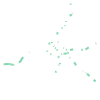

In [27]:
cascaded_union(df.seg_id[:100].apply(lambda x: shp_dict[x]))

In [15]:
df.to_csv(f'{PROJECT_PATH}/output/waze_12_etrims.csv')